#  Bioassay

In [28]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

## Contents
{:.no_toc}
* 
{: toc}

Bioassay (commonly used shorthand for biological assay), or biological standardisation is a type of scientific experiment. Bioassays are typically conducted to measure the effects of a substance on a living organism and are essential in the development of new drugs and in monitoring environmental pollutants. Both are procedures by which the potency (pharmacology) or the nature of a substance is estimated by studying its effects on living matter.

## The experiments 

In this experiment 5 animals were tested for various doses and the number of deaths were recorded. The  death rate is usually modeled as logit$^{-1}$ with two parameters (see below). The goal is to estimate those parameters and be able to infer death rates as a function of dose. 

In [29]:
n=5
X=np.array([-0.86,-0.30,-0.05,0.73])
Y=np.array([0,1,3,5])

This is a success-failure experiment with failure=death (morbid, I know).

## Setting up the posterior

The likelihood since is a success/fail experiment is expressed as a Binomial:

$$ P(D_i \vert \theta_i) = p(y_i, n_i \vert \theta_i) = {\rm Bionomial}( y_i, n_i \vert \theta_i)  \,\,\,\,    \rm{for}\,\, i=1, \ldots, 4$$

where $\theta_i$ is the rate of deaths in the ith experiment. Following our experiences in logistic regression, we shall model these as a $\rm{logit}^{-1}$:  

$$ \theta_i = {\rm logit}^{-1}(\alpha+\beta x_i) \,\,\,\, \rm{for} \,\, i=1, \ldots, 4$$

We use flat priors for $\alpha,\beta$: 

$$ p(\alpha, \beta) \propto 1 $$

Posterior: 

$$ p(\alpha, \beta \vert y) \propto p(\alpha, \beta) \prod_{i=1}^{k} p(y_i \vert \alpha, \beta, n_i, x_i) $$
$$ = 1 \prod_{i=1}^{k} [{\rm logit}^{-1}(\alpha+\beta x_i)]^{y_i} [ 1-{\rm logit}^{-1}(\alpha+\beta x_i)]^{n_i-y_i} $$



## Metropolis (and M-H) updating in multi-dimensional models

Notice that this is a 2 dimensional posterior. So we will be concerned with

1. Sampling from a 2D  distribution
2. marginalizing a 2D distribution to get the marginal posteriors for $\alpha$ and $\beta$.

Lets tackle the first. There are two ways to do this. The first is called **Blockwise Updating** in which we simply use a 2D-proposl function like a 2-D gaussian. This is probably what you would have done anyways. The advantage to that is that this is simple and you can make diagonal moves, but the disadvantage to this is that it can take a very long time to cover the space.

The second idea is **Componentwise Updating**. In this, you take steps only in one dimension at a time. You then accept or not, and repeat. The advantage is that you can make big strides. The disadvantage is that you may sample only in one axis for a bit, but this evens out in the long run. Also you can make only left-right and up-down moves. We'll have more to say about this when we cover Gibbs Sampling.

In [30]:
## invLogit this is the same as a sigmoid
logitInv= lambda x: np.exp(x)/(1.0+np.exp(x))

## posterior
def calc_posterior(a, b, y=Y, x=X):
    # Calculate joint posterior, given values for a, b 
    # x: dosage
    # y: number of deaths
    # a + b: parameters of the model
    p = np.product((logitInv(a+b*x)**y)*(1.0-logitInv( a+b*x))**(n-y))
    
    return p

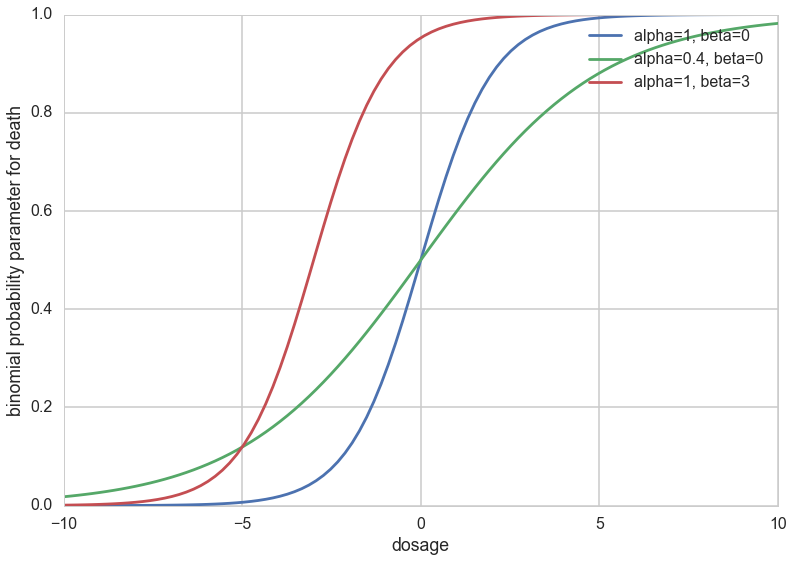

In [31]:
xx = np.linspace(-10,10,100)
plt.plot(xx, logitInv(xx), label="alpha=1, beta=0")
plt.plot(xx, logitInv(0.4*xx), label="alpha=0.4, beta=0")
plt.plot(xx, logitInv(xx+3), label="alpha=1, beta=3")
plt.xlabel("dosage")
plt.ylabel("binomial probability parameter for death")
plt.legend()


## Grid approximation to the posterior

In [32]:
# basically calculate the pdf on a grid
X1 = np.linspace(-3,7,101) # alpha
X2 = np.linspace(-10, 30,100) # beta
k=0;j=0
pp=np.zeros((101,100))
for x1 in X1:
    j=0
    for x2 in X2:
        pp[k,j]=calc_posterior(x1,x2)
        j +=1
    k +=1
    


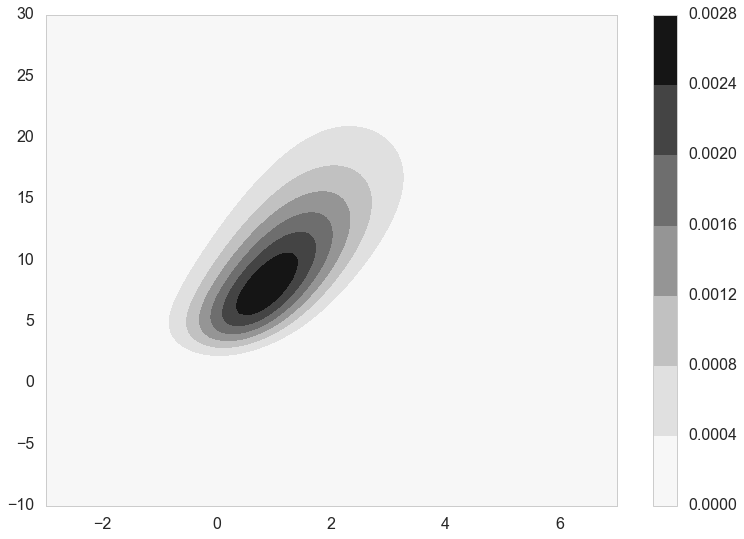

In [33]:
# look at the posterior distribution
plt.contourf(X1,X2,pp.T)
plt.colorbar()

## A metropolis in 2 dimensions

In [34]:
# this code is taken from https://github.com/fonnesbeck/Bios8366/blob/master/notebooks/Section4_2-MCMC.ipynb

rnorm = np.random.normal
runif = np.random.rand

def metropolis(n_iterations, initial_values, prop_std=[1,1], doPrint=True):
    #################################################################
    # function to sample using Metropolis 
    # (assumes proposal distribution is symmetric)
    # 
    # n_iterations:  number of iterations
    # initial_values: multidimensional start position for our chain
    # prop_std: standard deviation for Gaussian proposal distribution 
    ##################################################################
    
    
    #np.random.seed(seed=1)
    n_params = len(initial_values)
            
    # Initial proposal standard deviations
    # generates a list of length n_params
    #prop_sd = [prop_std]*n_params
    prop_sd = prop_std
    
    # Initialize trace for parameters
    trace = np.empty((n_iterations+1, n_params))
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    # the * assigns the arguments of the function according to the list elements
    current_prob = calc_posterior(*trace[0])
    
    # Initialize acceptance counts
    # We can use this to tune our step size
    accepted = [0]*n_params
    
    for i in range(n_iterations):
    
        if not i%10000 and doPrint: 
            print('Iterations left: ', n_iterations-i)
    
        # Grab current parameter values
        current_params = trace[i]
    
        # Get current value for parameter j
        p = trace[i].copy() 
        
        # loop over all dimensions
        for j in range(n_params):
            # proposed new value
            theta = rnorm(current_params[j], prop_sd[j])
            
            # Insert new value 
            p[j] = theta
    
            # Calculate posterior with proposed value
            proposed_prob = calc_posterior(*p)
    
            # Log-acceptance rate
            alpha = proposed_prob/current_prob
    
            # Sample a uniform random variate
            u = runif()
    
            # Test proposed value
            if (u) < alpha:
                # Accept
                trace[i+1,j] = theta
                current_prob = proposed_prob
                accepted[j] += 1
            else:
                # Stay put
                trace[i+1,j] = trace[i,j]
            
            # update p so we search the next dimension according
            # to the current result
            p[j] = trace[i+1,j]
    
    # return our samples and the number of accepted steps
    return trace, accepted

Create the sample for the posterior using MH

Let's look at the acceptance ratio to tune the stepsize
Note that this most probably should be better done after the burn in, but I don't want the simulations to run for too long during the lecture

array([ 0.31624,  0.3598 ])

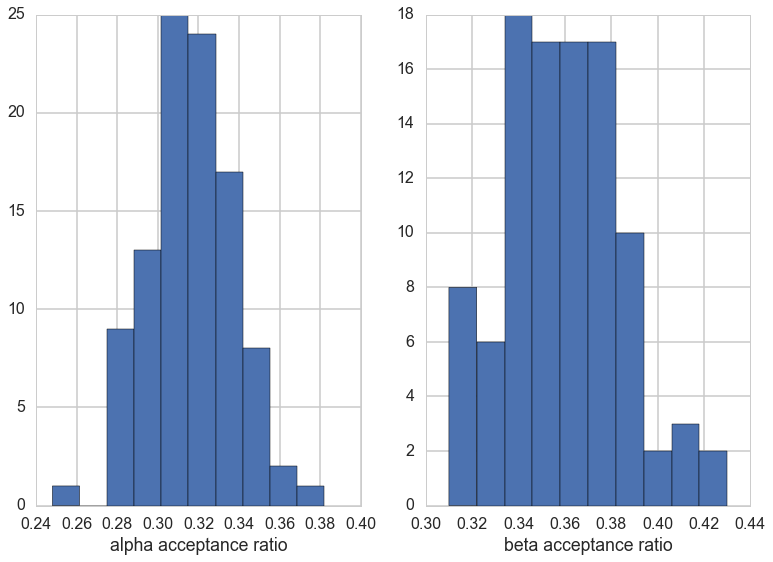

In [35]:
n_iter = 500
acc_ratios = []
for i in range(100):
    start_alpha = np.random.rand(1)*10 - 3
    start_beta = np.random.rand(1)*40 - 10
    trace, acc = metropolis(n_iter, (start_alpha, start_beta), [3.0,12.0], doPrint=False) #3.0, 12.0
    acc_ratios.append(acc/np.double(n_iter))

acc_ratios = np.array(acc_ratios)
plt.subplot(1,2,1)
plt.hist(acc_ratios[:,0])
plt.xlabel("alpha acceptance ratio")
plt.subplot(1,2,2)
plt.hist(acc_ratios[:,1])
plt.xlabel("beta acceptance ratio")

np.mean(acc_ratios, axis=0)

In [36]:
n_iter = 200000
trace, acc = metropolis(n_iter, (11,17), [3.0,12.0]) #[3.0,12.0])
acc/np.double(n_iter)

Iterations left:  200000
Iterations left:  190000
Iterations left:  180000
Iterations left:  170000
Iterations left:  160000
Iterations left:  150000
Iterations left:  140000
Iterations left:  130000
Iterations left:  120000
Iterations left:  110000
Iterations left:  100000
Iterations left:  90000
Iterations left:  80000
Iterations left:  70000
Iterations left:  60000
Iterations left:  50000
Iterations left:  40000
Iterations left:  30000
Iterations left:  20000
Iterations left:  10000


array([ 0.31394 ,  0.357835])

###  Marginal Posteriors

Getting marginal posteriors is ultra simple. You dont have to do anything! Just by counting up all the samples at a given $\alpha$ bin, you are adding over all the samples in the joing $p(\alpha, \beta)$ posteriot which have values in that bin. In other words, you are performing:

$$\int p(\alpha, \beta) d\beta.$$

In [37]:
burnin = 10000    # MY BURN IN 
# throw away the burnin samples
newtrace = trace[burnin:,]
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

In [44]:
alpha.shape

(200000,)

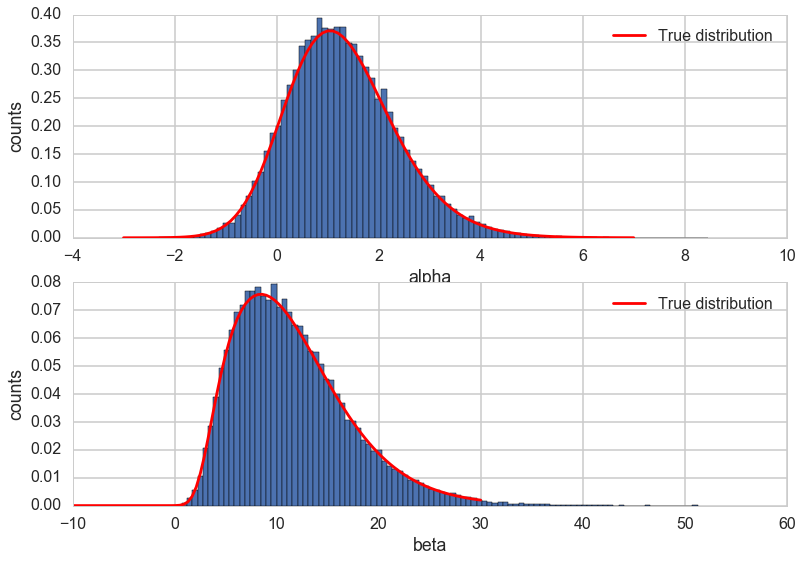

In [38]:
# histogram of alpha
plt.subplot(2,1,1) 
fig=plt.hist(alpha, bins=100, normed=True)
xx= np.linspace(-3,7,101)
pp_a = np.sum(pp, axis=1)
plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("alpha")
plt.ylabel("counts")

# histogram of beta
plt.subplot(2,1,2) 
fig=plt.hist(beta, bins=100, normed=True)
xx = np.linspace(-10, 30,100)
pp_b = np.sum(pp, axis=0)
plt.plot(xx, pp_b*1.5, 'r', label=u'True distribution') 
plt.legend()
plt.xlabel("beta")
plt.ylabel("counts")

### looking at traces

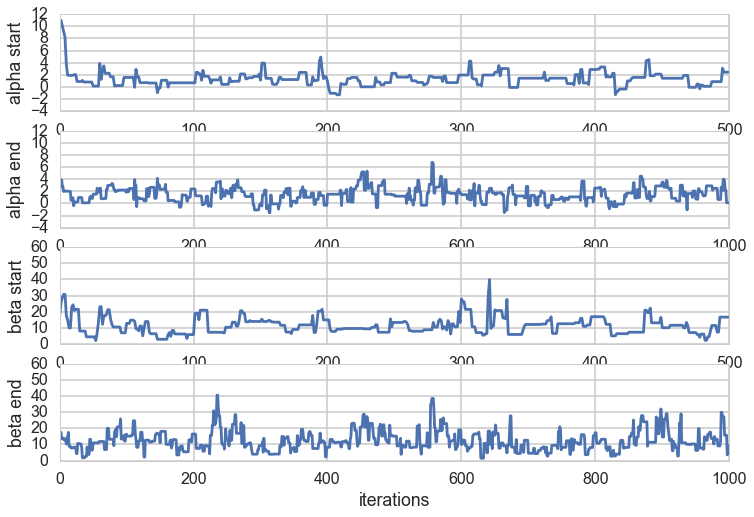

In [40]:
plt.figure(figsize=[12,8])

burnin = 500    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

# trace plot for alpha during burnin
plt.subplot(4,1,1) 
plt.plot(trace[:burnin,0])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha start")

# trace plot for alpha at the end 
# where we hopefully converged
plt.subplot(4,1,2) 
plt.plot(alpha[-2*burnin:])
plt.ylim(-4,12)
plt.xlabel("iterations")
plt.ylabel("alpha end")

# trace plot for beta during burnin
plt.subplot(4,1,3) 
plt.plot(trace[:burnin,1])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta start")

# trace plot for beta at the end 
# where we hopefully converged
plt.subplot(4,1,4) 
plt.plot(beta[-2*burnin:])
plt.ylim(0,60)
plt.xlabel("iterations")
plt.ylabel("beta end")


One technique to look for conergence is to plot multiple histograms for different subsets. These should look similar to each other.

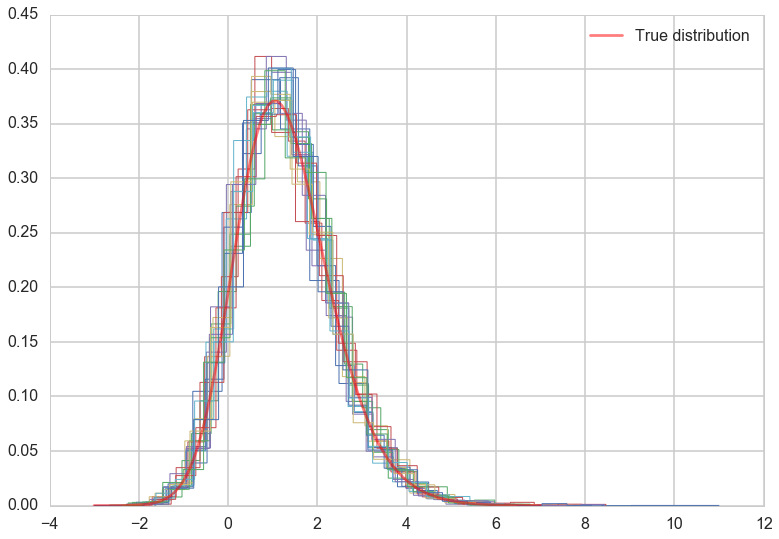

In [48]:
burnin = 1    # MY BURN IN 
# throw away the burnin samples
alpha = trace[burnin:,0]; beta=trace[burnin:,1]

subsetSize = 10000
xx= np.linspace(-3,7,101)
pp_a = np.sum(pp, axis=1)
plt.plot(xx, pp_a*6.0, 'r', label=u'True distribution', alpha=0.5) 
for i in range(20):
    #plt.hist(alpha[subsetSize*i:subsetSize*(i+1)], alpha=0.4)
    plt.hist(alpha[subsetSize*i:subsetSize*(i+1)], histtype="step", normed=True, bins=20, lw=1)
plt.legend();

Another technique is to simulate multiple chains, from different starting points. The final values these chains are plotted in a histogram. Then we continue these chains for more iterations, and plot a similar histogram. Repeat and see what we get. This is left as an exercise.

In all of this, one thing to keep in mind is that you should do this separately for each parameter.